In [12]:
#load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import matplotlib as mpl
from sklearn import linear_model
departments=pd.read_csv('/home/user_ds/qianpeng/data/data/departments.csv')
aisles=pd.read_csv('/home/user_ds/qianpeng/data/data/aisles.csv')
products=pd.read_csv('/home/user_ds/qianpeng/data/data/products.csv')
sample_submission=pd.read_csv('/home/user_ds/qianpeng/data/data/sample_submission.csv')
order_products_train=pd.read_csv('/home/user_ds/qianpeng/data/data/order_products__train.csv')
order_products_prior=pd.read_csv('/home/user_ds/qianpeng/data/data/order_products__prior.csv')
orders=pd.read_csv('/home/user_ds/qianpeng/data/data/orders.csv')
orders_prior=orders[orders.eval_set=='prior']

In [13]:
import random
import numpy as np
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [14]:
#group data together
data1=pd.merge(order_products_prior,orders_prior,on='order_id',how='left')
data2=pd.merge(data1,products,on='product_id',how='left')

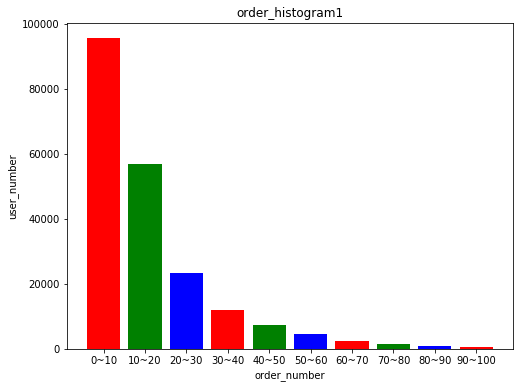

In [15]:
# the number of orders for all users

data_user_orders_num=orders.groupby('user_id')['order_id'].count()
source_data = {}
for i in range(10):
    source_data[str(10*i)+'~'+str(10*(i+1))]=len([x for x in list(data_user_orders_num) if x>=i*10 and x<(i+1)*10])
    

    
font_size=10
fig_size=(8,6)    
mpl.rcParams['font.size']=font_size
mpl.rcParams['figure.figsize']=fig_size
bar_width=0.3

 
x_axis = tuple(source_data.keys())
y_axis = tuple(source_data.values())
#assign color
plt.bar(x_axis, y_axis, color='rgb')  
# descrpitions for x-axis, y-axis
plt.xlabel('order_number')  
plt.ylabel("user_number") 
plt.title("order_histogram1") 
plt.show()


In [16]:
#the average number of products in each order for all users
data_user_products_num1=order_products_prior.groupby('order_id')['product_id'].count()
data_user_products_num1=pd.DataFrame(data_user_products_num1)
data_user_products_num1['order_id']=list(data_user_products_num1.index)
data_user_products_num1.columns=['product_num','order_id']
data_user_products_num2=pd.merge(data_user_products_num1,orders[['order_id','user_id']],on='order_id',how='left')
data_user_products_num3=data_user_products_num2.groupby('user_id')['product_num'].agg(['sum','count'])
data_user_products_num3['bl']=data_user_products_num3['sum']/data_user_products_num3['count']

/usr/local/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 'order_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [17]:
data_user_products_num3.head()

,sum,count,bl
user_id,,,
1,59,10,5.900000
2,195,14,13.928571
3,88,12,7.333333
4,18,5,3.600000
5,37,4,9.250000


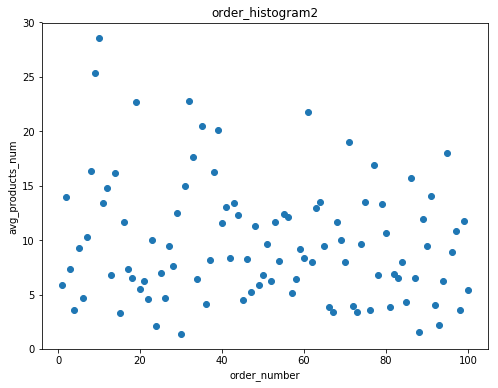

In [22]:
#the average number of products in each order for all users
plt.scatter(data_user_products_num3.index[0:100], list(data_user_products_num3.bl)[0:100])
plt.xlabel('user_id')  
plt.ylabel("avg_products_num") 
plt.title("order_histogram2")  
plt.show()

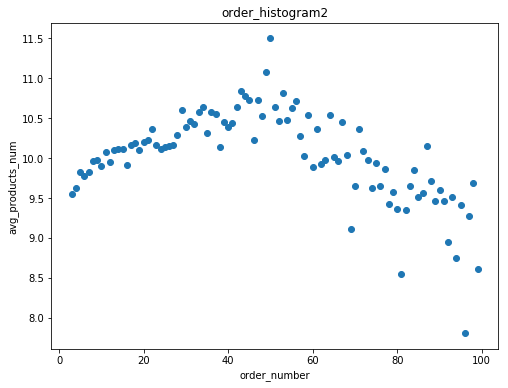

In [23]:
#the average number of products in each order for users have 4-100 orders
data_user_products_num4=data_user_products_num3.groupby('count')['bl'].mean()
plt.scatter(data_user_products_num4.index, list(data_user_products_num4))
# descrpitions for x-axis, y-axis
plt.xlabel('order_number') 
plt.ylabel("avg_products_num")  
plt.title("order_histogram2")  
plt.show()

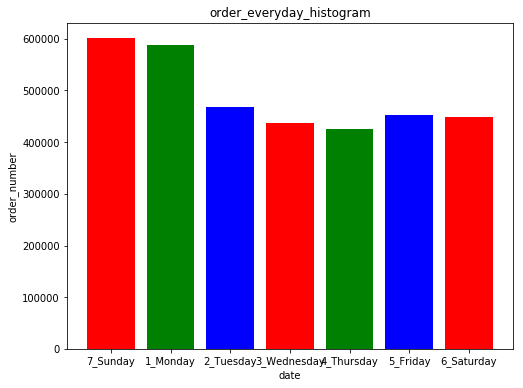

In [24]:
#the time of orders in each day per week
data_user_orders_day_num=orders.groupby('order_dow')['order_id'].count()
days=['7_Sunday','1_Monday','2_Tuesday','3_Wednesday','4_Thursday','5_Friday','6_Saturday']
day_num=list(data_user_orders_day_num)
    
plt.bar(days, day_num, color='rgb')  
# descrpitions for x-axis, y-axis
plt.xlabel('date')  
plt.ylabel("order_number")  
plt.title("order_everyday_histogram")  
plt.show()


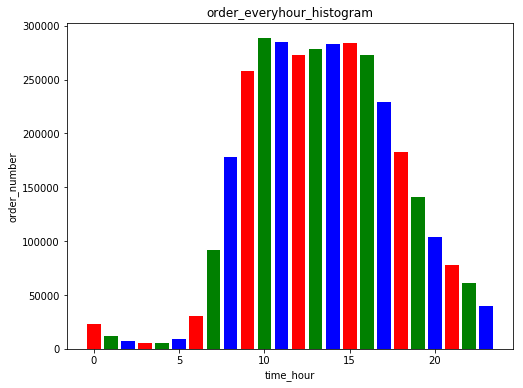

In [25]:
#the distribution of orders in each hour per day
data_user_orders_hour_num=orders.groupby('order_hour_of_day')['order_id'].count()
hour_num=list(data_user_orders_hour_num)
    
plt.bar(range(24), hour_num, color='rgb')  
# descrpitions for x-axis, y-axis
plt.xlabel('time_hour') 
plt.ylabel("order_number") 
plt.title("order_everyhour_histogram")  
plt.show()

/usr/local/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 'department_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


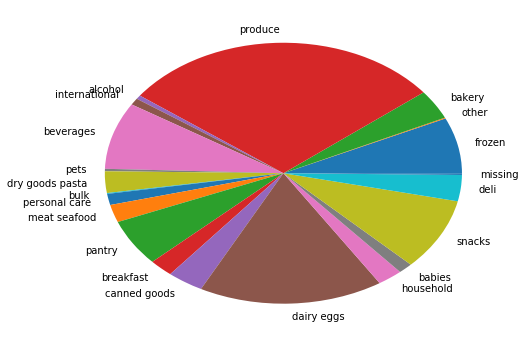

In [9]:
#the distribution of all products in each department 
product_num=pd.merge(order_products_prior,products,on='product_id',how='left')

product_num1=product_num.groupby('department_id').count()
product_num2=pd.DataFrame(product_num1)[['order_id']]
product_num2['department_id']=product_num2.index
product_num2.columns=['num','department_id']
product_num3=pd.merge(product_num2,departments,on='department_id',how='left')
plt.pie(x=list(product_num3.num), labels=list(product_num3.department))
product_num4=data2[['department_id','reordered','order_id']].groupby(['department_id','reordered']).count()

In [11]:
#wordcloud for high-demand products
from wordcloud import WordCloud
import re
product_name=list(data2.product_name)
product_name=[re.sub(' ','_',x) for x in product_name]
product_name1=' '.join(product_name)

# descrpitions for x-axis, y-axis
wc = WordCloud(
    font_path='simhei.ttf',     
    background_color='white',   
    width=800,
    height=500,
    max_font_size=80,           
    min_font_size=10,
    max_words=10000
)
wc.generate(product_name1[0:1000000])
plt.imshow(wc)

/usr/local/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 'department_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


([<matplotlib.patches.Wedge at 0x7f2c2991bba8>,
 [Text(1.07429,0.236423,'frozen'),
  Text(0.996742,0.465302,'other'),
  Text(0.935323,0.578939,'bakery'),
  Text(-0.0171602,1.09987,'produce'),
  Text(-0.893891,0.64106,'alcohol'),
  Text(-0.919396,0.603913,'international'),
  Text(-1.05263,0.319326,'beverages'),
  Text(-1.09967,0.0269541,'pets'),
  Text(-1.09739,-0.0757306,'dry goods pasta'),
  Text(-1.08661,-0.171112,'bulk'),
  Text(-1.07745,-0.221605,'personal care'),
  Text(-1.04594,-0.340612,'meat seafood'),
  Text(-0.928955,-0.589103,'pantry'),
  Text(-0.754012,-0.800915,'breakfast'),
  Text(-0.605642,-0.918258,'canned goods'),
  Text(0.0492508,-1.0989,'dairy eggs'),
  Text(0.657563,-0.881822,'household'),
  Text(0.75248,-0.802356,'babies'),
  Text(0.967061,-0.524207,'snacks'),
  Text(1.09271,-0.12646,'deli'),
  Text(1.09998,-0.00736687,'missing')])

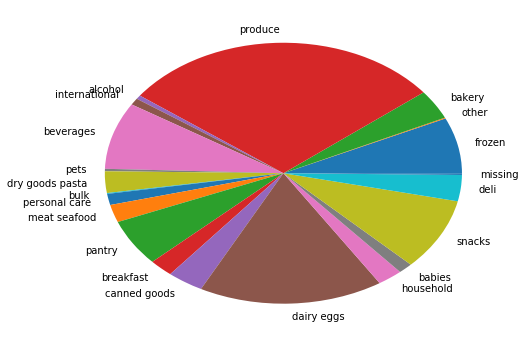

In [12]:
#the distribution of all products in each department 
product_num=pd.merge(order_products_prior,products,on='product_id',how='left')
product_num1=product_num.groupby('department_id').count()
product_num2=pd.DataFrame(product_num1)[['order_id']]
product_num2['department_id']=product_num2.index
product_num2.columns=['num','department_id']
product_num3=pd.merge(product_num2,departments,on='department_id',how='left')
plt.pie(x=list(product_num3.num), labels=list(product_num3.department))
 

In [13]:
product_num4=data2[['department_id','reordered','order_id']].groupby(['department_id','reordered']).count()
product_num4=pd.DataFrame(product_num4)
product_num5=pd.DataFrame(list(range(1,22)))

In [14]:
a=[]
for i in range(21):
    a.append(product_num4.iloc[i*2+1,0])

In [15]:
product_num5['num']=a
product_num5.columns=['department_id','reordered_num']

In [16]:
product_num6=pd.merge(product_num5,product_num3,on='department_id',how='left')

In [17]:
product_num6.reordered_num=product_num6.reordered_num/product_num6.num

In [18]:
product_num6.num=product_num6.num/sum(product_num6.num)

In [19]:
product_num6.columns

Index(['department_id', 'reordered_num', 'num', 'department'], dtype='object')

In [20]:
regr = linear_model.LinearRegression()

In [21]:
x=[[a] for a in list(product_num6['reordered_num'])]
y=[[a] for a in list(product_num6['num'])]

In [22]:
regr.fit(x,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

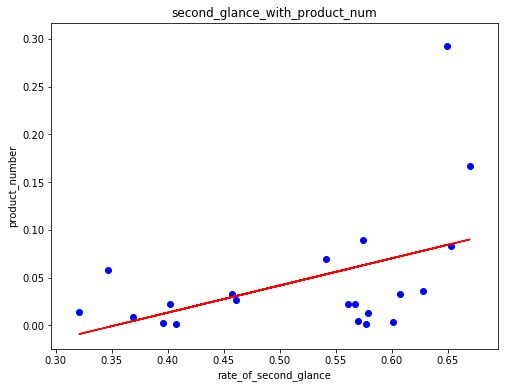

In [23]:
#relationship between rate of second glance and the number of products
plt.xlabel('rate_of_second_glance')  
plt.ylabel("product_number")  
plt.title("second_glance_with_product_num") 
plt.scatter(x,y, color='blue')
plt.plot(x,regr.predict(x),color='red')

In [24]:
#the relationship between products' users and products' sales volume
department_user_num=[]
for i in range(1,22):
    a=len(set(data2[data2.department_id==i].user_id))
    department_user_num.append(a)
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


In [18]:
department_user_num1=[x/206209 for x in department_user_num]

In [19]:
product_num6['department_user_num']=department_user_num1

In [21]:
x=[[a] for a in list(product_num6['department_user_num'])]
y=[[a] for a in list(product_num6['num'])]

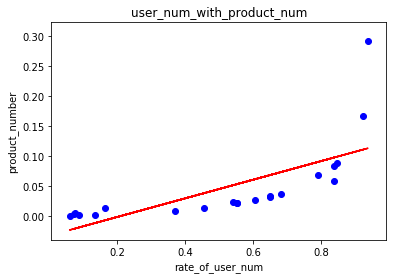

In [22]:
#the relationship between products' users and products' sales volume
plt.xlabel('rate_of_user_num') 
plt.ylabel("product_number")  
plt.title("user_num_with_product_num") 
regr.fit(x,y)
plt.scatter(x,y, color='blue')
plt.plot(x,regr.predict(x),color='red')

/usr/local/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 'department_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


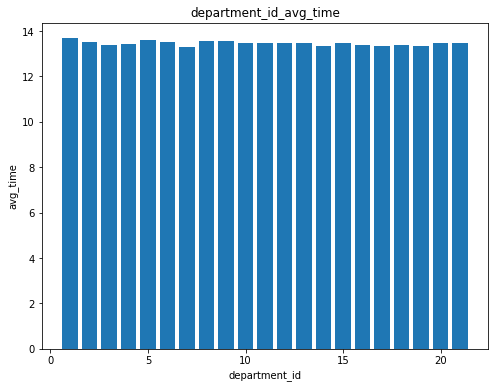

In [25]:
#analysis of shopping time
product_time=data2.groupby('department_id')['order_hour_of_day'].mean()
product_time=pd.DataFrame(product_time)
product_time['department_id']=product_time.index
product_time1=pd.merge(product_time,departments,on='department_id',how='left')
plt.xlabel('department_id') 
plt.ylabel("avg_time")  
plt.title("department_id_avg_time") 
plt.bar(list(range(1,22)),list(product_time1.order_hour_of_day))
plt.show()

In [26]:
#barchart for total orders each hour of a day
product_time=data2.groupby('product_id')['order_hour_of_day'].mean()
product_time=pd.DataFrame(product_time)
product_time['product_id']=product_time.index

In [27]:
num_product_different_time=[]
for i in range(24):
    a=product_time[(product_time.order_hour_of_day>=i) & (product_time.order_hour_of_day<i+1)].shape[0]
    num_product_different_time.append(a)

<BarContainer object of 24 artists>

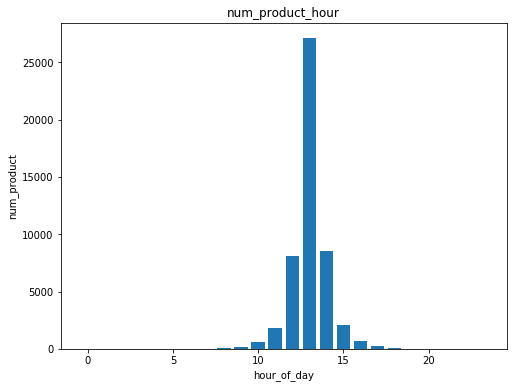

In [28]:
#barchart for total orders each hour of a day
plt.xlabel('hour_of_day')  
plt.ylabel("num_product")  
plt.title("num_product_hour") 
plt.bar(list(range(24)), list(num_product_different_time))

开始处理特征，建立预测模型

In [35]:
#Feature Engeerning
#1.1 gmcs imply to the total number of orders for each users；
#1.2 gmpl imply to reorder ratio and reorder time interval；
#1.3 user_fgl imply to reorder ratio for each user；
#1.4 producty_num_everytime is the average number of products；
#1.5 num_product the total number of products for each user；
#1.6 num_distinct_product the number of distinct product of user 

In [26]:
#1.1 gmcs imply to the total number of orders for each users
gmcs=orders_prior.groupby(['user_id'])['order_id'].count()
gmcs=pd.DataFrame(gmcs)
gmcs['user_id']=gmcs.index
gmcs.columns=['gmcs','user_id']

In [27]:
gmcs.shape

(206209, 2)

In [28]:
#1.2 gmpl imply to reorder ratio and reorder time interval；
# drops Null values in days_since-prior_order
orders_prior.days_since_prior_order=orders_prior.days_since_prior_order.replace({np.NaN:0})

/usr/local/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [29]:
gmpl=orders_prior.groupby(['user_id'])['days_since_prior_order'].mean()
gmpl=pd.DataFrame(gmpl)
gmpl['user_id']=gmpl.index
gmpl.columns=['gmpl','user_id']

In [30]:
#1.3 user_fgl imply to reorder ratio for each user
user_fgl=data2.groupby('user_id')['reordered'].mean()
user_fgl=pd.DataFrame(user_fgl)
user_fgl['user_id']=user_fgl.index
user_fgl.columns=['user_fgl','user_id']

In [31]:
#1.4 product_num_everytime is the average number of products

In [32]:
a1=data2.groupby('order_id')['add_to_cart_order'].max()
a1=pd.DataFrame(a1)
a1['order_id']=a1.index
a1.columns=['product_num_everytime','order_id']

In [33]:
product_num_everytime=pd.merge(a1,orders_prior,on='order_id',how='left')

/usr/local/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 'order_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [34]:
product_num_everytime=product_num_everytime.groupby('user_id')['product_num_everytime'].mean()
product_num_everytime=pd.DataFrame(product_num_everytime)
product_num_everytime['user_id']=product_num_everytime.index
product_num_everytime.columns=['product_num_everytime','user_id']

In [35]:
#1.5 num_product is the total number of products for each user
num_product=data2.groupby('user_id')['product_id'].count()
num_product=pd.DataFrame(num_product)
num_product['user_id']=num_product.index
num_product.columns=['num_product','user_id']

In [36]:
#1.6 num_distinct_product the number of distinct product of user
def f1(x):
    return len(set(x))

num_distinct_prodct=data2.groupby('user_id')['product_id'].apply(f1)
num_distinct_prodct=pd.DataFrame(num_distinct_prodct)
num_distinct_prodct['user_id']=num_distinct_prodct.index
num_distinct_prodct.columns=['num_distinct_prodct','user_id']

In [37]:
data2_last_order=data2.groupby('user_id')['order_number'].max()
data2_last_order=pd.DataFrame(data2_last_order)
data2_last_order['user_id']=data2_last_order.index
data2_last_order.columns=['num','user_id']

In [38]:
data2_last_order1=data2_last_order

In [39]:
data2_last_order=pd.merge(data2,data2_last_order,on='user_id',how='left')
data2_last_order=data2_last_order[data2_last_order.order_number==data2_last_order.num]
data2_last_order=data2_last_order.groupby('user_id')['reordered'].mean()
data2_last_order=pd.DataFrame(data2_last_order)
data2_last_order['user_id']=data2_last_order.index
data2_last_order.columns=['last_order_reorderd','user_id']

/usr/local/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 'user_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [40]:
data_all1=pd.merge(gmcs,gmpl,on='user_id',how='left')
data_all1=pd.merge(data_all1,user_fgl,on='user_id',how='left')
data_all1=pd.merge(data_all1,product_num_everytime,on='user_id',how='left')
data_all1=pd.merge(data_all1,num_product,on='user_id',how='left')
data_all1=pd.merge(data_all1,num_distinct_prodct,on='user_id',how='left')
data_all1=pd.merge(data_all1,data2_last_order,on='user_id',how='left')

/usr/local/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 'user_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [41]:
data2=pd.merge(data2,data2_last_order1,on='user_id',how='left')

/usr/local/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 'user_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [43]:
# 2.1 product_of_order_num is users order ratio over total orders
product_of_order_num=data2.groupby('product_id')['order_id'].count()
product_of_order_num=pd.DataFrame(product_of_order_num)
product_of_order_num['product_of_order_num']=product_of_order_num.index
product_of_order_num.columns=['product_of_order_num','product_id']

In [44]:
#2.2 product_of_user_num is the number of users buying specific products
product_of_user_num=data2.groupby('product_id')['user_id'].apply(f1)
product_of_user_num=pd.DataFrame(product_of_user_num)
product_of_user_num['product_of_user_num']=product_of_user_num.index
product_of_user_num.columns=['product_of_user_num','product_id']

In [45]:
#2.3 product_of_second_order_num is the number of reorder orders
product_of_second_order_num=data2[data2.reordered==1].groupby('product_id')['order_id'].count()
product_of_second_order_num=pd.DataFrame(product_of_second_order_num)
product_of_second_order_num['product_of_second_order_num']=product_of_second_order_num.index
product_of_second_order_num.columns=['product_of_second_order_num','product_id']

In [46]:
#2.4 product_of_second_user_num is the number of reorder users
product_of_second_user_num=data2[data2.reordered==1].groupby('product_id')['user_id'].apply(f1)
product_of_second_user_num=pd.DataFrame(product_of_second_user_num)
product_of_second_user_num['product_of_second_user_num']=product_of_second_user_num.index
product_of_second_user_num.columns=['product_of_second_user_num','product_id']

In [47]:
#2.5 product_fgl is the reorder ratio of the product
product_fgl=data2.groupby('product_id')['reordered'].mean()
product_fgl=pd.DataFrame(product_fgl)
product_fgl['product_id']=product_fgl.index
product_fgl.columns=['product_fgl','product_id']

In [48]:
#2.6 product_location is the location in the cart or add to cart order
product_location=data2.groupby('product_id')['add_to_cart_order'].mean()
product_location=pd.DataFrame(product_location)
product_location['product_id']=product_location.index
product_location.columns=['product_location','product_id']

In [49]:
data_all2=pd.merge(product_of_order_num,product_of_user_num,on='product_id',how='left')
data_all2=pd.merge(data_all2,product_of_second_order_num,on='product_id',how='left')
data_all2=pd.merge(data_all2,product_of_second_user_num,on='product_id',how='left')
data_all2=pd.merge(data_all2,product_fgl,on='product_id',how='left')
data_all2=pd.merge(data_all2,product_location,on='product_id',how='left')

/usr/local/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 'product_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [50]:
data_all2.shape

(49677, 7)

In [51]:
data2.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,num
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,8
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,8
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,8
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13,8
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13,8


In [53]:
data3=data2[data2.order_number< data2.num]
data4=data2[data2.order_number== data2.num]

#constructing positive examples
import random
product_id_all=list(set(data2.product_id))
user_id_all=list(set(data2.user_id))


#constructing negative examples base on what products user did not buy on their last orders
#reorder ratio of users is 0.6
#choose 0.7 from previously purchased items 0.3 from total products for construtng negative examples
择
#creat dic for each user
data5=data3[['user_id','product_id']]
map_dict={}

# k=0
# for i in user_id_all:
#     k+=1
#     map_dict[i]=list(set(data5[data5['user_id']==i]['product_id']))
#     if k%10000==0:
#         print(k)
        
        
#save file for later use
# map1=pd.DataFrame()
# map1['user_id']=map_dict.keys()
# map1['product_id']=  map_dict.values()
#map1.to_csv('/home/user_ds/qianpeng/script/studying/map_dict.csv')




map2=pd.read_csv('/home/user_ds/qianpeng/script/studying/map_dict.csv')
user_id=list(map2.user_id)
product_id=list(map2.product_id)
product_id=[x[1:][0:-1].split(',') for x in product_id]
product_id=[[int(x1) for x1 in x] for x in product_id]
map_dict1=dict(zip(user_id,product_id))
map_dict=map_dict1


user_id=[]
product_id=[]
data_label0=pd.DataFrame()
for i in user_id_all:
    product_id=random.sample(map_dict[i],int(len(map_dict[i])*0.7*0.3))
    product_id.extend(random.sample(product_id_all,int(len(map_dict[i])*0.3*0.3)))
    user_id=[i]*len(product_id)
    a=pd.DataFrame(user_id)
    a['product_id']=product_id
    data_label0=data_label0.append(a)
data_label0.columns=['user_id','product_id']
#finishing positive and negative examples

/usr/local/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [54]:
data_label0.head()

,user_id,product_id
0,1.0,26088.0
1,1.0,25133.0
2,1.0,10258.0
3,1.0,4833.0
0,2.0,16521.0


In [55]:
#3.1 orders_num_buy_the_product is the number of users bought the product
aa=data3.groupby(['user_id','product_id'])['order_id'].count()
aa=pd.DataFrame(aa)

In [56]:
a=list(aa.index)
user_id=[x[0] for x in a]
product_id=[x[1] for x in a]

In [57]:
aa['user_id']=user_id
aa['product_id']=product_id
aa.columns=['orders_num_buy_the_product','user_id','product_id']

In [58]:
aa.head()

orders_num_buy_the_product  user_id  product_id
user_id product_id                                                 
1       196                                  9        1         196
        10258                                8        1       10258
        10326                                1        1       10326
        12427                                9        1       12427
        13032                                2        1       13032

In [59]:
#negative examples result
data_label0_new=pd.merge(data_label0,aa,on=['user_id','product_id'],how='left')
data_label0_new=pd.merge(data_label0_new,gmcs,on='user_id',how='left')
data_label0_new['bl']=data_label0_new['orders_num_buy_the_product']/data_label0_new['gmcs']
del data_label0_new['gmcs']

/usr/local/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 'user_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 'product_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [60]:
data_label0_new.head()

,user_id,product_id,orders_num_buy_the_product,bl
0,1.0,26088.0,2.0,0.200000
1,1.0,25133.0,7.0,0.700000
2,1.0,10258.0,8.0,0.800000
3,1.0,4833.0,NaN,NaN
4,2.0,16521.0,1.0,0.071429


In [61]:
#positive examples result
data_label1_new=pd.merge(data4[['user_id','product_id']],aa,on=['user_id','product_id'],how='left')
data_label1_new=pd.merge(data_label1_new,gmcs,on='user_id',how='left')
data_label1_new['bl']=data_label1_new['orders_num_buy_the_product']/data_label1_new['gmcs']
del data_label1_new['gmcs']

/usr/local/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 'user_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 'product_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [62]:
data_label1_new.head()

,user_id,product_id,orders_num_buy_the_product,bl
0,59897,9755,13.0,0.684211
1,59897,31487,NaN,NaN
2,59897,37510,1.0,0.052632
3,59897,14576,12.0,0.631579
4,59897,22105,NaN,NaN


In [63]:
# 3.2 order_num_not_buy_the_product is the number of days not buying

In [64]:
aa=data3.groupby(['user_id','product_id'])['order_number'].max()
aa=data3.groupby(['user_id','product_id'])['order_number'].max()
aa=pd.DataFrame(aa)
a=list(aa.index)
user_id=[x[0] for x in a]
product_id=[x[1] for x in a]
aa['user_id']=user_id
aa['product_id']=product_id
aa.columns=['order_number','user_id','product_id']

In [65]:
bb=pd.merge(aa,data2[['user_id','product_id','order_number','num']],on=['user_id','product_id','order_number'],how='left')
bb['order_num_not_buy_the_product']=bb['num']-bb['order_number']-1

/usr/local/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 'user_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 'product_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [66]:
del bb['order_number']
del bb['num']
order_num_not_buy_the_product=bb

In [67]:
order_num_not_buy_the_product.head()

,user_id,product_id,order_num_not_buy_the_product
0,1,196,0
1,1,10258,0
2,1,10326,4
3,1,12427,0
4,1,13032,2


In [68]:
#positive examples
data_label1_new=pd.merge(data_label1_new,order_num_not_buy_the_product,on=['user_id','product_id'],how='left')

In [69]:
#negative examples
data_label0_new=pd.merge(data_label0_new,order_num_not_buy_the_product,on=['user_id','product_id'],how='left')

In [70]:
# 3.3   first_and_last_buy_the_product is the first/last orders of users
first_and_last_buy_the_product=data3.groupby(['user_id','product_id'])['order_number'].agg(['min','max'])
first_and_last_buy_the_product=pd.DataFrame(first_and_last_buy_the_product)

a=list(first_and_last_buy_the_product.index)
user_id=[x[0] for x in a]
product_id=[x[1] for x in a]

In [71]:
first_and_last_buy_the_product['user_id']=user_id
first_and_last_buy_the_product['product_id']=product_id

In [72]:
first_and_last_buy_the_product=pd.merge(first_and_last_buy_the_product,gmcs,on='user_id',how='left')
first_and_last_buy_the_product['min']=first_and_last_buy_the_product['min']/first_and_last_buy_the_product['gmcs']
first_and_last_buy_the_product['max']=first_and_last_buy_the_product['max']/first_and_last_buy_the_product['gmcs']
first_and_last_buy_the_product.columns=['first_buy_the_product','last_buy_the_product','user_id','product_id','gmcs']
del first_and_last_buy_the_product['gmcs']

/usr/local/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 'user_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [73]:
first_and_last_buy_the_product.head()

,first_buy_the_product,last_buy_the_product,user_id,product_id
0,0.1,0.9,1,196
1,0.2,0.9,1,10258
2,0.5,0.5,1,10326
3,0.1,0.9,1,12427
4,0.2,0.7,1,13032


In [74]:
#positive examples
data_label1_new=pd.merge(data_label1_new,first_and_last_buy_the_product,on=['user_id','product_id'],how='left')

In [75]:
#negative examples
data_label0_new=pd.merge(data_label0_new,first_and_last_buy_the_product,on=['user_id','product_id'],how='left')

In [76]:
data_label1_new.head()

,user_id,product_id,orders_num_buy_the_product,bl,order_num_not_buy_the_product,first_buy_the_product,last_buy_the_product
0,59897,9755,13.0,0.684211,0.0,0.052632,0.947368
1,59897,31487,NaN,NaN,NaN,NaN,NaN
2,59897,37510,1.0,0.052632,2.0,0.842105,0.842105
3,59897,14576,12.0,0.631579,1.0,0.105263,0.894737
4,59897,22105,NaN,NaN,NaN,NaN,NaN


In [77]:
data_label0_new.head()

,user_id,product_id,orders_num_buy_the_product,bl,order_num_not_buy_the_product,first_buy_the_product,last_buy_the_product
0,1.0,26088.0,2.0,0.200000,7.0,0.100000,0.200000
1,1.0,25133.0,7.0,0.700000,0.0,0.300000,0.900000
2,1.0,10258.0,8.0,0.800000,0.0,0.200000,0.900000
3,1.0,4833.0,NaN,NaN,NaN,NaN,NaN
4,2.0,16521.0,1.0,0.071429,0.0,0.928571,0.928571


In [78]:
#3.4 days_not_buy_the_product is the number of days not buying product B or the sepcific product

In [79]:
aa=data3.groupby(['user_id','product_id'])['order_number'].max()
aa=pd.DataFrame(aa)
a=list(aa.index)
user_id=[x[0] for x in a]
product_id=[x[1] for x in a]
aa['user_id']=user_id
aa['product_id']=product_id
aa.columns=['order_number','user_id','product_id']

In [80]:
bb=pd.merge(aa,orders_prior[['user_id','order_number','days_since_prior_order']],on=['user_id'],how='left')

/usr/local/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 'user_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [81]:
bb=bb[bb.order_number_y>bb.order_number_x]

In [82]:
bb=bb.groupby(['order_number_x','user_id','product_id'])['days_since_prior_order'].sum()

In [83]:
bb=pd.DataFrame(bb)
a=list(bb.index)
user_id=[x[1] for x in a]
product_id=[x[2] for x in a]
bb['user_id']=user_id
bb['product_id']=product_id
bb.columns=['days_not_buy_the_product','user_id','product_id']

In [84]:
#positive examples
data_label1_new=pd.merge(data_label1_new,bb,on=['user_id','product_id'],how='left')

/usr/local/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 'user_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 'product_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [85]:
#negative examples
data_label0_new=pd.merge(data_label0_new,bb,on=['user_id','product_id'],how='left')

/usr/local/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 'user_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 'product_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [86]:
data_label0_new.head()

,user_id,product_id,orders_num_buy_the_product,bl,order_num_not_buy_the_product,first_buy_the_product,last_buy_the_product,days_not_buy_the_product
0,1.0,26088.0,2.0,0.200000,7.0,0.100000,0.200000,161.0
1,1.0,25133.0,7.0,0.700000,0.0,0.300000,0.900000,30.0
2,1.0,10258.0,8.0,0.800000,0.0,0.200000,0.900000,30.0
3,1.0,4833.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2.0,16521.0,1.0,0.071429,0.0,0.928571,0.928571,13.0


In [87]:
data_label1_new.head()

,user_id,product_id,orders_num_buy_the_product,bl,order_num_not_buy_the_product,first_buy_the_product,last_buy_the_product,days_not_buy_the_product
0,59897,9755,13.0,0.684211,0.0,0.052632,0.947368,25.0
1,59897,31487,NaN,NaN,NaN,NaN,NaN,NaN
2,59897,37510,1.0,0.052632,2.0,0.842105,0.842105,77.0
3,59897,14576,12.0,0.631579,1.0,0.105263,0.894737,47.0
4,59897,22105,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
#3.5 the reorder ratio of the product B or the specific

In [89]:
aa=data3.groupby(['user_id','product_id'])['order_number'].count()
aa=pd.DataFrame(aa)
a=list(aa.index)
user_id=[x[0] for x in a]
product_id=[x[1] for x in a]
aa['user_id']=user_id
aa['product_id']=product_id
aa.columns=['gmcs','user_id','product_id']

In [90]:
bb=orders_prior.groupby('user_id')['days_since_prior_order'].sum()
bb=pd.DataFrame(bb)
bb['user_id']=bb.index
bb.columns=['time1','user_id']

In [91]:
bb=pd.merge(aa,bb,on='user_id',how='left')

/usr/local/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 'user_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [92]:
bb['time_gmpl']=bb['time1']/bb['gmcs']

In [93]:
del bb['gmcs']
del bb['time1']

In [94]:
bb.shape

(12422758, 3)

In [95]:
#positive examples
data_label1_new=pd.merge(data_label1_new,bb,on=['user_id','product_id'],how='left')

In [96]:
#negative examples
data_label0_new=pd.merge(data_label0_new,bb,on=['user_id','product_id'],how='left')

In [97]:
data_label0_new.shape

(3519197, 9)

In [98]:
data_all1.head()

,gmcs,user_id,gmpl,user_fgl,product_num_everytime,num_product,num_distinct_prodct,last_order_reorderd
0,10,1,17.600000,0.694915,5.900000,59,18,0.666667
1,14,2,14.142857,0.476923,13.928571,195,102,0.625000
2,12,3,11.083333,0.625000,7.333333,88,33,1.000000
3,5,4,11.000000,0.055556,3.600000,18,17,0.000000
4,4,5,10.000000,0.378378,9.250000,37,23,0.666667


In [99]:
data_all2.head()

,product_of_order_num,product_id,product_of_user_num,product_of_second_order_num,product_of_second_user_num,product_fgl,product_location
0,1852,1,716,1136.0,276.0,0.613391,5.801836
1,90,2,78,12.0,8.0,0.133333,9.888889
2,277,3,74,203.0,36.0,0.732852,6.415162
3,329,4,182,147.0,64.0,0.446809,9.507599
4,15,5,6,9.0,4.0,0.600000,6.466667


In [100]:
##group data by orders and non-orders for later split test/train
data_label0_new=pd.merge(data_label0_new,data_all1,on='user_id',how='left')
data_label0_new=pd.merge(data_label0_new,data_all2,on='product_id',how='left')

In [101]:
data_label1_new=pd.merge(data_label1_new,data_all1,on='user_id',how='left')
data_label1_new=pd.merge(data_label1_new,data_all2,on='product_id',how='left')

In [102]:
data_label1_new.shape

(2139788, 22)

In [103]:
data_label0_new.shape

(3519197, 22)

In [104]:
data_label0_new['product_id_user_id']=data_label0_new['product_id'].astype(str)+data_label0_new['user_id'].astype(str)

In [105]:
data_label1_new['product_id_user_id']=data_label1_new['product_id'].astype(str)+data_label1_new['user_id'].astype(str)

In [106]:
data_label_jj=pd.merge(data_label0_new,data_label1_new,on=['user_id','product_id'],how='inner')

In [107]:
data_label_jj.shape

(248964, 44)

In [108]:
product_id_user_id=list(data_label_jj.product_id_user_id_x)

In [109]:
data_label0_new=data_label0_new[ -data_label0_new['product_id_user_id'].isin(product_id_user_id)]

In [110]:
data_label0_new.shape

(3270233, 23)

In [111]:
del data_label1_new['product_id_user_id']
del data_label0_new['product_id_user_id']

In [112]:
#updating data
data_label1_new.columns

Index(['user_id', 'product_id', 'orders_num_buy_the_product', 'bl',
       'order_num_not_buy_the_product', 'first_buy_the_product',
       'last_buy_the_product', 'days_not_buy_the_product', 'time_gmpl', 'gmcs',
       'gmpl', 'user_fgl', 'product_num_everytime', 'num_product',
       'num_distinct_prodct', 'last_order_reorderd', 'product_of_order_num',
       'product_of_user_num', 'product_of_second_order_num',
       'product_of_second_user_num', 'product_fgl', 'product_location'],
      dtype='object')

In [113]:
#updating data
data_label0_new.columns

Index(['user_id', 'product_id', 'orders_num_buy_the_product', 'bl',
       'order_num_not_buy_the_product', 'first_buy_the_product',
       'last_buy_the_product', 'days_not_buy_the_product', 'time_gmpl', 'gmcs',
       'gmpl', 'user_fgl', 'product_num_everytime', 'num_product',
       'num_distinct_prodct', 'last_order_reorderd', 'product_of_order_num',
       'product_of_user_num', 'product_of_second_order_num',
       'product_of_second_user_num', 'product_fgl', 'product_location'],
      dtype='object')

In [114]:
data_label0_new['label']=0
data_label1_new['label']=1

In [115]:
data_label1_new.shape

(2139788, 23)

In [116]:
data_label_new=data_label0_new.append(data_label1_new)

In [117]:
del data_label_new['user_id']
del data_label_new['product_id']

In [118]:
data_label_new= data_label_new.copy().replace({np.nan:-100}).astype(float)

In [119]:
y=data_label_new.label

In [120]:
# Split test and train data based on orders and non-orders and ramdon sampling for test set
X_train,X_test,y_train,y_test = train_test_split(data_label_new,y,test_size=1000000,random_state=1)

In [121]:
del X_train['label']

In [122]:
#strat train model XGBoost
X_train.columns

Index(['orders_num_buy_the_product', 'bl', 'order_num_not_buy_the_product',
       'first_buy_the_product', 'last_buy_the_product',
       'days_not_buy_the_product', 'time_gmpl', 'gmcs', 'gmpl', 'user_fgl',
       'product_num_everytime', 'num_product', 'num_distinct_prodct',
       'last_order_reorderd', 'product_of_order_num', 'product_of_user_num',
       'product_of_second_order_num', 'product_of_second_user_num',
       'product_fgl', 'product_location'],
      dtype='object')

In [123]:
data_label_new.head()

,orders_num_buy_the_product,bl,order_num_not_buy_the_product,first_buy_the_product,last_buy_the_product,days_not_buy_the_product,time_gmpl,gmcs,gmpl,user_fgl,...,num_product,num_distinct_prodct,last_order_reorderd,product_of_order_num,product_of_user_num,product_of_second_order_num,product_of_second_user_num,product_fgl,product_location,label
0,2.0,0.200000,7.0,0.100000,0.200000,161.0,88.0,10.0,17.600000,0.694915,...,59.0,18.0,0.666667,2523.0,1163.0,1360.0,471.0,0.539041,6.495838,0.0
3,-100.0,-100.000000,-100.0,-100.000000,-100.000000,-100.0,-100.0,10.0,17.600000,0.694915,...,59.0,18.0,0.666667,389.0,195.0,194.0,72.0,0.498715,11.089974,0.0
4,1.0,0.071429,0.0,0.928571,0.928571,13.0,198.0,14.0,14.142857,0.476923,...,195.0,102.0,0.625000,10531.0,5291.0,5240.0,1868.0,0.497579,9.962966,0.0
5,1.0,0.071429,0.0,0.928571,0.928571,13.0,198.0,14.0,14.142857,0.476923,...,195.0,102.0,0.625000,17332.0,6989.0,10343.0,3004.0,0.596757,8.967228,0.0
6,1.0,0.071429,0.0,0.928571,0.928571,13.0,198.0,14.0,14.142857,0.476923,...,195.0,102.0,0.625000,75165.0,17964.0,57201.0,10647.0,0.761006,7.512632,0.0


In [124]:
xgb = xgboost.XGBClassifier(n_jobs=110,n_estimators=2000,max_depth=10,colsample_bytree=0.9)
xgb.fit(X_train,y_train)

[14:53:10] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2000,
       n_jobs=110, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [125]:
del X_test['label']
y_pred = xgb.predict(X_test)

In [126]:
len(y_pred)

1000000

In [128]:
#accuracy for XGB
print("accuracy: %f" %accuracy_score(y_test[0:1000000],y_pred))

f1: 0.769495
precision: 0.797370
recall: 0.743503
accuracy: 0.823846


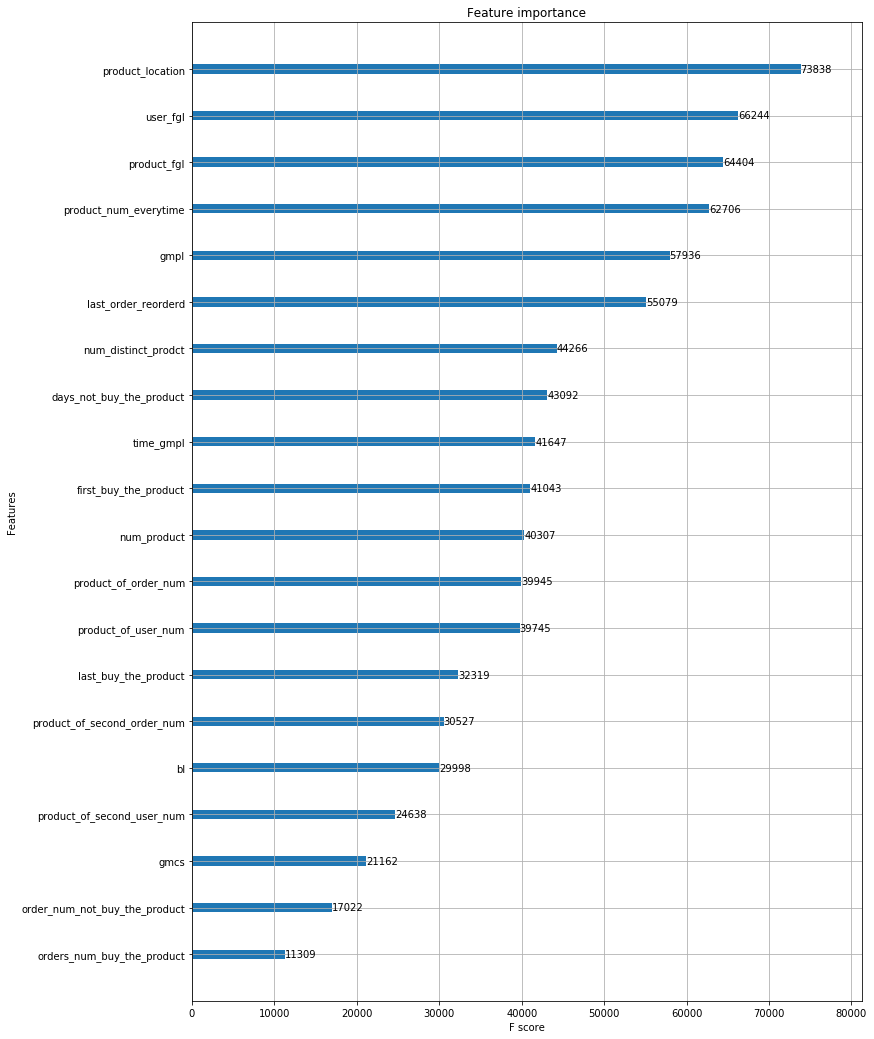

In [129]:
#feature importance for XGBoost
import matplotlib.pyplot as plt
feature_importance_table = pd.DataFrame(np.array(list(X_train.columns)))
feature_importance_table = pd.concat([feature_importance_table,pd.DataFrame(xgb.feature_importances_)],axis=1)
feature_importance_table.columns = ['feature_name','weight']
feature_importance_table['weight'].idxmax()
fig,ax = plt.subplots(figsize=(12,18))
xgboost.plot_importance(xgb,ax=ax)
plt.show()

In [106]:
##strat train model Logistic Regression

In [108]:
from  sklearn import linear_model

In [109]:
logit=linear_model.LogisticRegression()

In [110]:
logit.fit(X_train,y_train)

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [112]:
del X_test['label']
y_pred = logit.predict(X_test)

In [113]:
#accuracy for LR
print("accuracy: %f" %accuracy_score(y_test[0:1000000],y_pred))

f1: 0.671423
precision: 0.698678
recall: 0.646215
accuracy: 0.749889
